# Lexicon-based Approaches

COST Action Training School in Computational Opinion Analysis – COpA

Johannes B. Gruber \| VU Amsterdam

# Examples

In [ ]:
# just some code to install packages quickly on Colab
if (Sys.getenv("COLAB_RELEASE_TAG") != "") {
  download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_focal.sh",
                "add_cranapt_focal.sh")
  Sys.chmod("add_cranapt_focal.sh", "0755")
  system("./add_cranapt_focal.sh")
}
# install missing packages
required <- c("ngramr", "tidyverse", "tidytext", "yardstick", "curl", "cli", "tidylo")
missing <- setdiff(required, installed.packages()[,"Package"])
install.packages(missing, Ncpus = 4)

# attach required packages
library(ngramr)
library(tidyverse)
library(tidytext)
library(yardstick)
library(tidylo)

## 1. Non-Consupmtive Research with Google Books

Taken from Duneier (2017): Ghetto: The Invention of a Place, the History
of an Idea

**RQ**: How did the meaning of ghetto change over time? **Method**:
Non-Consumptive Research with the Google Books Ngram Viewer

In [ ]:
ng  <- ngram(
  phrases = c("ghetto", 
              "(Warsaw ghetto) + (Jewish ghetto)", 
              "(black ghetto) + (negro ghetto)"), 
  year_start = 1920,
  year_end = 1975,
  smoothing = 0,
  count = TRUE
) |> 
  group_by(Year) |> 
  mutate(pct = Count / Count[Phrase == "ghetto"]) |> 
  filter(Phrase != "ghetto")

ggplot(ng, aes(x = Year, y = pct, colour = Phrase)) +
  geom_line() +
  theme(legend.position = "bottom")

### Exercise 1: Create your own plot

In [ ]:
total <- "band"
ng  <- ngram(
  phrases = c(total, 
              "(paper band) + (rubber band)", 
              "(music band) + (pop band) + (rock band) + (boy band)",
              "frequency band"), 
  year_start = 1800,
  year_end = 2019,
  smoothing = 0,
  count = TRUE
) |> 
  mutate(Phrase = fct_recode(Phrase, "total" = total)) |> 
  group_by(Year) |>  
  mutate(pct = Count / Count[Phrase == "total"]) |> 
  filter(Phrase != "total")

ggplot(ng, aes(x = Year, y = pct, colour = Phrase)) +
  geom_line() +
  theme(legend.position = "bottom")

## 2. Sentiment Analysis

This part is taken from [Atteveldt, Trilling, and Arcíla (2021) Chapter
11.2](https://cssbook.net/content/chapter11.html#sec-reviewdataset). We
first get the data for this, which consists of movie reviews from the
IMDB database (Maas et al. 2011).

In [ ]:
# you can ignore this part where I download and process the data. But I left it
# in here in case you find it interesting.
data_file <- "imdb.rds"
if (!file.exists(data_file)) {
  message("Downloading data")
  # download into a temporary folder and unpack archive
  temp <- file.path(tempdir(), "imdb") 
  dir.create(temp, recursive = TRUE)
  curl::curl_download("https://cssbook.net/d/aclImdb_v1.tar.gz",
                      file.path(temp, "imdb.tar.gz"), quiet = FALSE)
  untar(file.path(temp, "imdb.tar.gz"), exdir = temp)
  files <- list.files(temp, 
                      pattern = ".txt", 
                      recursive = TRUE,
                      full.names = TRUE)
  # read in files
  imdb <- map(files, function(f) {
    tibble(
      file = f,
      text = readLines(f, warn = FALSE)
    )
  }) |> 
    bind_rows() |> 
    mutate(label = str_extract(file, "/pos/|/neg/"),
           label = str_remove_all(label, "/"),
           label = factor(label),
           dataset = str_extract(file, "/test/|/train/"),
           dataset = str_remove_all(dataset, "/"),
           dataset = factor(dataset),) |>
    filter(!is.na(label)) |>
    select(-file) |> 
    # adding unique IDs for later
    mutate(id = row_number())
  saveRDS(imdb, data_file)
} else {
  message("Using cached data")
  imdb <- readRDS(data_file)
}

We download a dictionary from the *Computational Analysis of
Communication* website (Atteveldt, Trilling, and Arcíla (2021)), which
consists of a list of positive, and one list of negative words.

In [ ]:
poswords = "https://cssbook.net/d/positive.txt"
negwords = "https://cssbook.net/d/negative.txt"
sentiment_dict <- bind_rows(
  tibble(word = scan(poswords, what = "character"), value = 1),
  tibble(word = scan(negwords, what = "character"), value = -1)
)
sentiment_dict[c(1:5, 5660:5664), ]

We then go through all reviews and construct a sentiment score by
looking up each word and adding up its score:

In [ ]:
scores_df <- imdb |> 
  # For speed, we only take the first 100 reviews
  head(100) |> 
  # This splits up the texts into its individual words
  unnest_tokens(output = "word", input = "text", drop = FALSE) |> 
  # We attach the sentiment_dict to the text data.frame. inner_join drops
  # rows where the word is not in both data.frames
  inner_join(sentiment_dict, by = "word") |>
  # For each text, we calcuate the sum of values
  group_by(id) |> 
  summarise(senti_score = sum(value),
            text = head(text, 1))

head(scores_df)

More commonly, people normalize the absolute count of positive and
negative words to construct a score that ranges from -1 (most negative
sentiment) to +1 (most positive sentiment). We can also apply the
mapping function now that we discussed earlier:

N positive terms \>= N negative terms = positive text N positive terms
\< N negative terms = negative text

In [ ]:
scores_df <- imdb |> 
  # For speed, we only take the first 100 reviews
  head(100) |>  
  unnest_tokens(output = "token", input = "text", drop = FALSE) |> 
  inner_join(sentiment_dict, by = c("token" = "word")) |> 
  group_by(id) |>
  # here, we normalise the outcome and assign a sentiment category
  summarise(senti_score = sum(value) / n(),
            sentiment = ifelse(senti_score >= 0, "pos", "neg"),
            text = head(text, 1))

head(scores_df)

We can plot these results to get an impression how often each category
was predicted and how strong the senti_score was in these cases.

In [ ]:
scores_df |> 
  mutate(id = fct_reorder(as.character(id), senti_score)) |> 
  ggplot(aes(x = senti_score, y = id, fill = sentiment)) +
  geom_col() +
  labs(y = NULL, fill = NULL)

We can validate this approach by comparing the measured sentiment to the
real sentiment, as given in the dataset:

In [ ]:
validation_df <- scores_df |> 
  select(-text) |> 
  left_join(imdb, by = "id")

# have a look at the new data.frame
validation_df |> 
  select(id, label, sentiment, senti_score)

An easy way to validate performance is to calculate how often the
prediction and the real sentiment match:

In [ ]:
validation_df |> 
  count(match = label == sentiment)

However, the absolute count of matches, or accuracy, is prone to errors,
since it does not take into account chance. For example, by taking only
the first 100 reviews, we happen to have gather data that has just
negative cases:

In [ ]:
validation_df |> 
  count(label)

So while optimising our mapping function we could accidentally make a
wrong adjustment:

In [ ]:
scores_df_error <- imdb |> 
  head(100) |>  
  unnest_tokens(output = "token", input = "text", drop = FALSE) |> 
  inner_join(sentiment_dict, by = c("token" = "word")) |> 
  group_by(id) |>
  summarise(senti_score = sum(value) / n(),
            sentiment = ifelse(senti_score >= 0, "neg", "neg"),
            #                 see the error here --^
            text = head(text, 1))

scores_df_error |> 
  select(-text) |> 
  left_join(imdb, by = "id") |> 
  count(match = label == sentiment)

Now suddenly our accuracy is perfect! This is why we use a couple of
metrics that control for chance:

In [ ]:
conf_matrix <- table(validation_df$label, validation_df$sentiment)
ml_metrics <- metric_set(accuracy, precision, recall, f_meas, kap)
conf_matrix
ml_metrics(conf_matrix)

### Exercise 2: Discuss the results

-   Based on the example text below, which issues do you see arise from
    this approach to measuring sentiment?

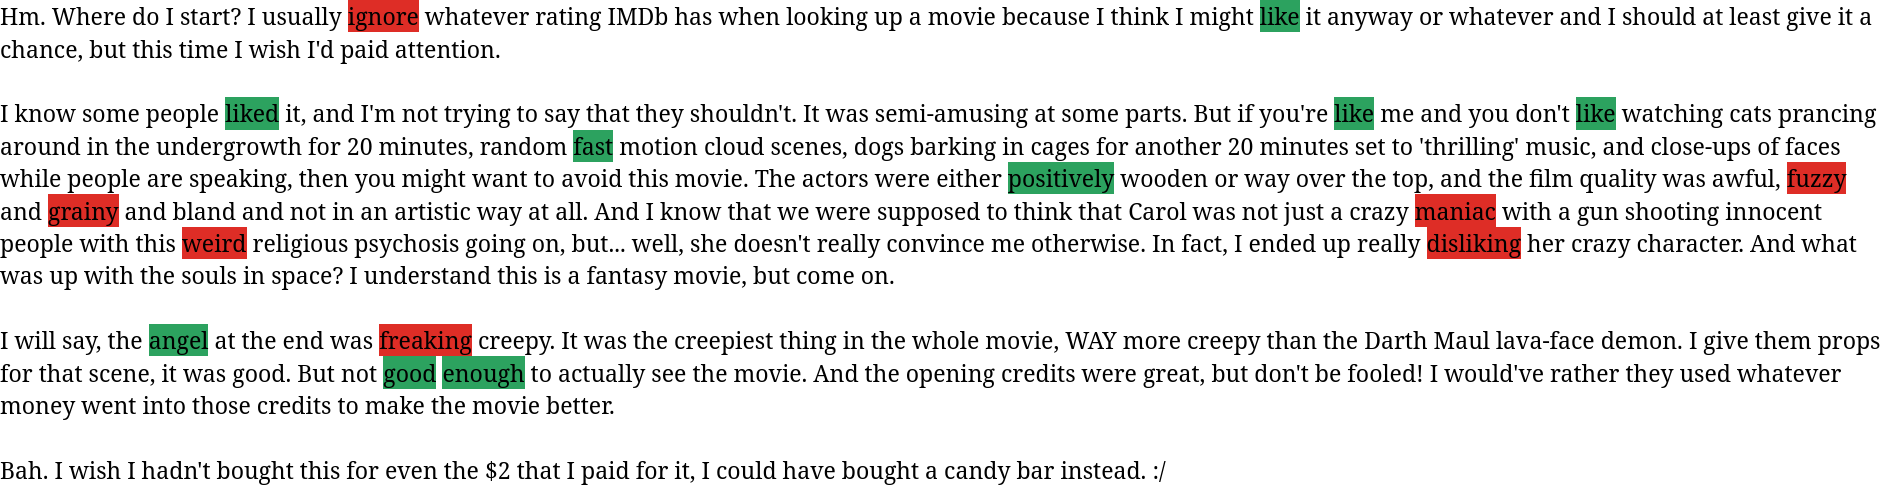

-   This COST action is about opinions. Would you say:
    1.  the provided data contains opinions?
    2.  the approach we looked at is suitable to measure these opinions?

## 3. Build your own dictionary

We already know the labels in this data. So let’s use it to see what
would be a good dictionary! First, let’s count the words and see which
ones show up most often in the ‘pos’ and in the ‘neg’ data.

In [ ]:
imdb_count <- imdb |> 
  unnest_tokens(output = "token", input = "text") |> 
  count(label, token, sort = TRUE)
imdb_count

Okay, this is arguably not helpful at all. Let’s use a statistical
weighting to see not only which words are common, but which ones are
showing up statistically much more often in one of the two document
groups:

In [ ]:
imdb_logodds <- imdb_count |>
  bind_log_odds(label, token, n) |> 
  arrange(-log_odds_weighted)
imdb_logodds

Now let’s plot this!

In [ ]:
imdb_logodds |>
    group_by(label) |>
    slice_max(log_odds_weighted, n = 15) |>
    ungroup() |>
    mutate(token = reorder(token, log_odds_weighted)) |>
    ggplot(aes(log_odds_weighted, token, fill = label)) +
    geom_col(show.legend = FALSE) +
    facet_wrap(vars(label), scales = "free") +
    labs(y = NULL)

# References

Atteveldt, Wouter van, Damian Trilling, and Carlos Arcíla. 2021.
*Computational Analysis of Communication: A Practical Introduction to
the Analysis of Texts, Networks, and Images with Code Examples in Python
and R*. Hoboken, NJ: John Wiley & Sons. <https://cssbook.net>.

Duneier, Mitchell. 2017. *Ghetto: The Invention of a Place, the History
of an Idea*. First paperback edition. New York: Farrar, Straus; Giroux.

Maas, Andrew L., Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y.
Ng, and Christopher Potts. 2011. “Learning Word Vectors for Sentiment
Analysis.” In *Proceedings of the 49th Annual Meeting of the Association
for Computational Linguistics: Human Language Technologies*, 142–50.
Portland, Oregon, USA: Association for Computational Linguistics.
<http://www.aclweb.org/anthology/P11-1015>.